<a href="https://colab.research.google.com/github/kanishkjain1995/Learning-Tensorflow/blob/master/Learning_TensorFlow_(Ch_4_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import _pickle as cPickle
import os
import matplotlib.pyplot as plt
import time

In [0]:
def weight_variable(shape):
  initial_value = tf.truncated_normal(shape, stddev=0.1)
  weights = tf.Variable(initial_value, name="weights")
  return weights

In [0]:
def bias_variable(shape):
  initial_value = tf.constant(0.1, shape=shape)
  bias = tf.Variable(initial_value, name="bias")
  return bias

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

In [0]:
def max_pooling(x):
  return tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [0]:
def conv_layer(x, shape):
  W = weight_variable(shape)
  b = bias_variable([shape[3]])
  return tf.nn.relu(conv2d(x, W) + b)

In [0]:
def full_layer(x, shape):
  inp_shape = x.get_shape().as_list()[1]
  W = weight_variable([inp_shape, shape])
  b = bias_variable([shape])
  return tf.matmul(x, W) + b

# MNIST

In [0]:
DATA_DIR = "/tmp/data"
STEPS = 5000
BATCH_SIZE = 50

mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

x_reshape = tf.reshape(x, shape=[-1, 28, 28, 1])

conv_layer_1 = conv_layer(x_reshape, [5, 5 ,1 ,32])
max_pool_1 = max_pooling(conv_layer_1)

conv_layer_2 = conv_layer(max_pool_1, [5, 5, 32, 64])
max_pool_2 = max_pooling(conv_layer_2)

flatten_layer = tf.reshape(max_pool_2, [-1, 7*7*64])
fc_layer_1 = tf.nn.relu(full_layer(flatten_layer, 1024))


keep_prob = tf.placeholder(tf.float32, name="keep_prob")
dropout_1 = tf.nn.dropout(fc_layer_1, keep_prob=keep_prob)

y_pred = full_layer(dropout_1, 10)

W0708 05:10:19.655449 140347955152768 deprecation.py:506] From <ipython-input-22-1e869eadbcb3>:17: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
loss = tf.reduce_mean(loss)

In [0]:
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

In [0]:
correct_pred = tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init)
  
  for i in range(STEPS):
    x_train, y_train = mnist.train.next_batch(BATCH_SIZE)
    
    if(i%1000 == 0):
      acc = sess.run(accuracy, feed_dict={x:x_train, y_true:y_train, keep_prob:1.0})
      print("Step {:4}, Accuracy {:.2f}%".format(i, acc*100))
    sess.run(train_step, feed_dict={x:x_train, y_true:y_train, keep_prob:0.5})
    
  x_test = mnist.test.images.reshape(10, 1000, 784)
  y_test = mnist.test.labels.reshape(10, 1000, 10)
  test_accuracy = np.mean([sess.run(accuracy, feed_dict={x:x_test[i], y_true:y_test[i], keep_prob:1.0}) for i in range(10)])
  
print("Test Accuracy {:.2f}%".format(test_accuracy*100))

Step    0, Accuracy 2.00%
Step 1000, Accuracy 96.00%
Step 2000, Accuracy 98.00%
Step 3000, Accuracy 98.00%
Step 4000, Accuracy 100.00%
Test Accuracy 98.61%


# CIFAR10

In [0]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2019-07-08 15:46:19--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  62.1MB/s    in 2.6s    

2019-07-08 15:46:22 (62.1 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [0]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
def unpickle(file):
  with open(os.path.join(DATA_DIR, file), 'rb') as fo:
    dictionary = cPickle.load(fo, encoding='latin1')
  return dictionary

def one_hot(vec, labels=10):
  n = len(vec)
  out = np.zeros((n, labels))
  out[range(n), vec] = 1
  return out

In [0]:
class CifarLoader(object):
  def __init__(self, source_files):
    self._source = source_files
    self._i = 0
    self.images = None
    self.labels = None
    
  def load(self):
    data = [unpickle(f) for f in self._source]
    images = np.vstack([d['data'] for d in data])
    n = len(images)
    self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float)/255
    self.labels = one_hot(np.hstack([d['labels'] for d in data]), 10)
    return self
  
  def next_batch(self, batch_size):
    x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
    self._i = (self._i + batch_size)%len(self.images)
    return x, y

In [0]:
class CifarDataManager(object):
  def __init__(self):
    self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1,6)]).load()
    self.test = CifarLoader(["test_batch"]).load()

In [0]:
def display_image(images, size):
  n = len(images)
  plt.figure()
  plt.gca().set_axis_off()
  im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
  plt.imshow(im)
  plt.show()

In [0]:
d = CifarDataManager()

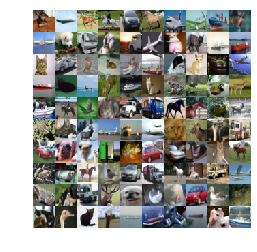

In [0]:
images = d.train.images
display_image(images, 10)

In [0]:
DATA_DIR = "./cifar-10-batches-py/"
BATCH_SIZE = 100
NUM_STEPS = 10000

In [0]:
tf.reset_default_graph()

### *Simple Model*

In [0]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv_1 = conv_layer(x, shape=[5, 5, 3, 32])
conv_pool_1 = max_pooling(conv_1)

conv_2 = conv_layer(conv_pool_1, shape=[5, 5, 32, 64])
conv_pool_2 = max_pooling(conv_2)

conv_3 = conv_layer(conv_pool_2, shape=[5, 5, 64, 128])
conv_pool_3 = max_pooling(conv_3)

conv_flat_1 = tf.reshape(conv_pool_3, shape=[-1, 4*4*128])
conv_drop_1 = tf.nn.dropout(conv_flat_1, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv_drop_1, 512))
full_drop_1 = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_pred = full_layer(full_drop_1, 10)

### *Small SOA Model*

In [0]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

c1, c2, c3 = 30, 50, 80
f1 = 500

conv1_1 = conv_layer(x, [3, 3, 3, c1])
conv1_2 = conv_layer(conv1_1, [3, 3, c1, c1])
conv1_3 = conv_layer(conv1_2, [3, 3, c1, c1])
conv1_pool = max_pooling(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

conv2_1 = conv_layer(conv1_drop, [3, 3, c1, c2])
conv2_2 = conv_layer(conv2_1, [3, 3, c2, c2])
conv2_3 = conv_layer(conv2_2, [3, 3, c2, c2])
conv2_pool = max_pooling(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

conv3_1 = conv_layer(conv2_drop, [3, 3, c2, c3])
conv3_2 = conv_layer(conv3_1, [3, 3, c3, c3])
conv3_3 = conv_layer(conv3_2, [3, 3, c3, c3])
conv3_pool = tf.nn.max_pool2d(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')

conv3_flat = tf.reshape(conv3_pool, shape=[-1, c3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, f1))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_pred = full_layer(full1_drop, 10)

In [0]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

W0708 15:46:32.485083 140644218754944 deprecation.py:323] From <ipython-input-21-fa99061bbbf8>:1: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
correct_pred = tf.equal(tf.argmax(y_true,1), tf.argmax(y_pred,1))
accuracy = 100*tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
opt = tf.train.AdamOptimizer(1e-3)
train_step = opt.minimize(loss)

In [0]:
def test(sess):
  x_test = cifar.test.images.reshape(10, 1000, 32, 32, 3)
  y_test = cifar.test.labels.reshape(10, 1000, 10)
  
  test_accuracy = np.mean([sess.run(accuracy, feed_dict={x:x_test[i], y_true:y_test[i], keep_prob:1.0}) for i in range(10)])
  print("Test Accuracy {:.2f}%".format(test_accuracy))

In [0]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init)
  
  for i in range(NUM_STEPS):
    x_train, y_train = cifar.train.next_batch(BATCH_SIZE)
    if i%1000 == 0:
      train_accuracy = sess.run(accuracy, feed_dict={x:x_train, y_true:y_train, keep_prob:1.0})
      print("Step {:5}, accuracy {:.2f}%".format(i, train_accuracy))
    sess.run(train_step, feed_dict={x:x_train, y_true:y_train, keep_prob:0.5})
    
  test(sess)

Step     0, accuracy 11.00%
Step  1000, accuracy 22.00%
Step  2000, accuracy 39.00%
Step  3000, accuracy 44.00%
Step  4000, accuracy 50.00%
Step  5000, accuracy 51.00%
Step  6000, accuracy 51.00%
Step  7000, accuracy 60.00%
Step  8000, accuracy 58.00%
Step  9000, accuracy 58.00%
Step 10000, accuracy 65.00%
Step 11000, accuracy 58.00%
Step 12000, accuracy 62.00%
Step 13000, accuracy 67.00%
Step 14000, accuracy 68.00%
Step 15000, accuracy 60.00%
Step 16000, accuracy 65.00%
Step 17000, accuracy 70.00%
Step 18000, accuracy 70.00%
Step 19000, accuracy 66.00%
Step 20000, accuracy 72.00%
Step 21000, accuracy 70.00%
Step 22000, accuracy 70.00%
Step 23000, accuracy 71.00%
Step 24000, accuracy 65.00%
Step 25000, accuracy 67.00%
Step 26000, accuracy 71.00%
Step 27000, accuracy 74.00%
Step 28000, accuracy 79.00%
Step 29000, accuracy 78.00%
Step 30000, accuracy 75.00%
Step 31000, accuracy 73.00%
Step 32000, accuracy 74.00%
Step 33000, accuracy 77.00%
Step 34000, accuracy 74.00%
Step 35000, accuracy